In [1]:
import pandas as pd

In [2]:
data = pd.read_csv('ludico.csv')
data.shape

(25, 13)

In [3]:
data.shape

(25, 13)

In [4]:
data.head()

,Marca temporal,Edad (años entero),Signo del zodiaco,Signo del zodiaco chino,Sexo (biológico),"Tamaño del zapato (22,23,24,etc)",Tiempo promedio diario que pasan en redes sociales (minutos),¿Tienes pareja?,¿Te gusta el reggaeton?,¿Te gusta el futbol?,¿Usas Tiktok?,Estatura (cms),Peso (kg)
0,7/9/2023 18:36:27,24,Acuario,Conejo,Hombre,28.0,180,Sí,Sí,Sí,Sí,183,80
1,7/9/2023 18:36:44,25,Virgo,Buey,Mujer,25.0,90,Sí,No,No,Sí,164,52
2,7/9/2023 18:36:48,30,Virgo,Mono,Mujer,24.0,120,Sí,Sí,No,No,152,65
3,7/9/2023 18:36:50,23,Virgo,Serpiente,Hombre,26.0,180,No,Sí,Sí,Sí,165,63
4,7/9/2023 18:36:50,26,Capricornio,Buey,Hombre,28.0,60,Sí,Sí,No,Sí,175,70


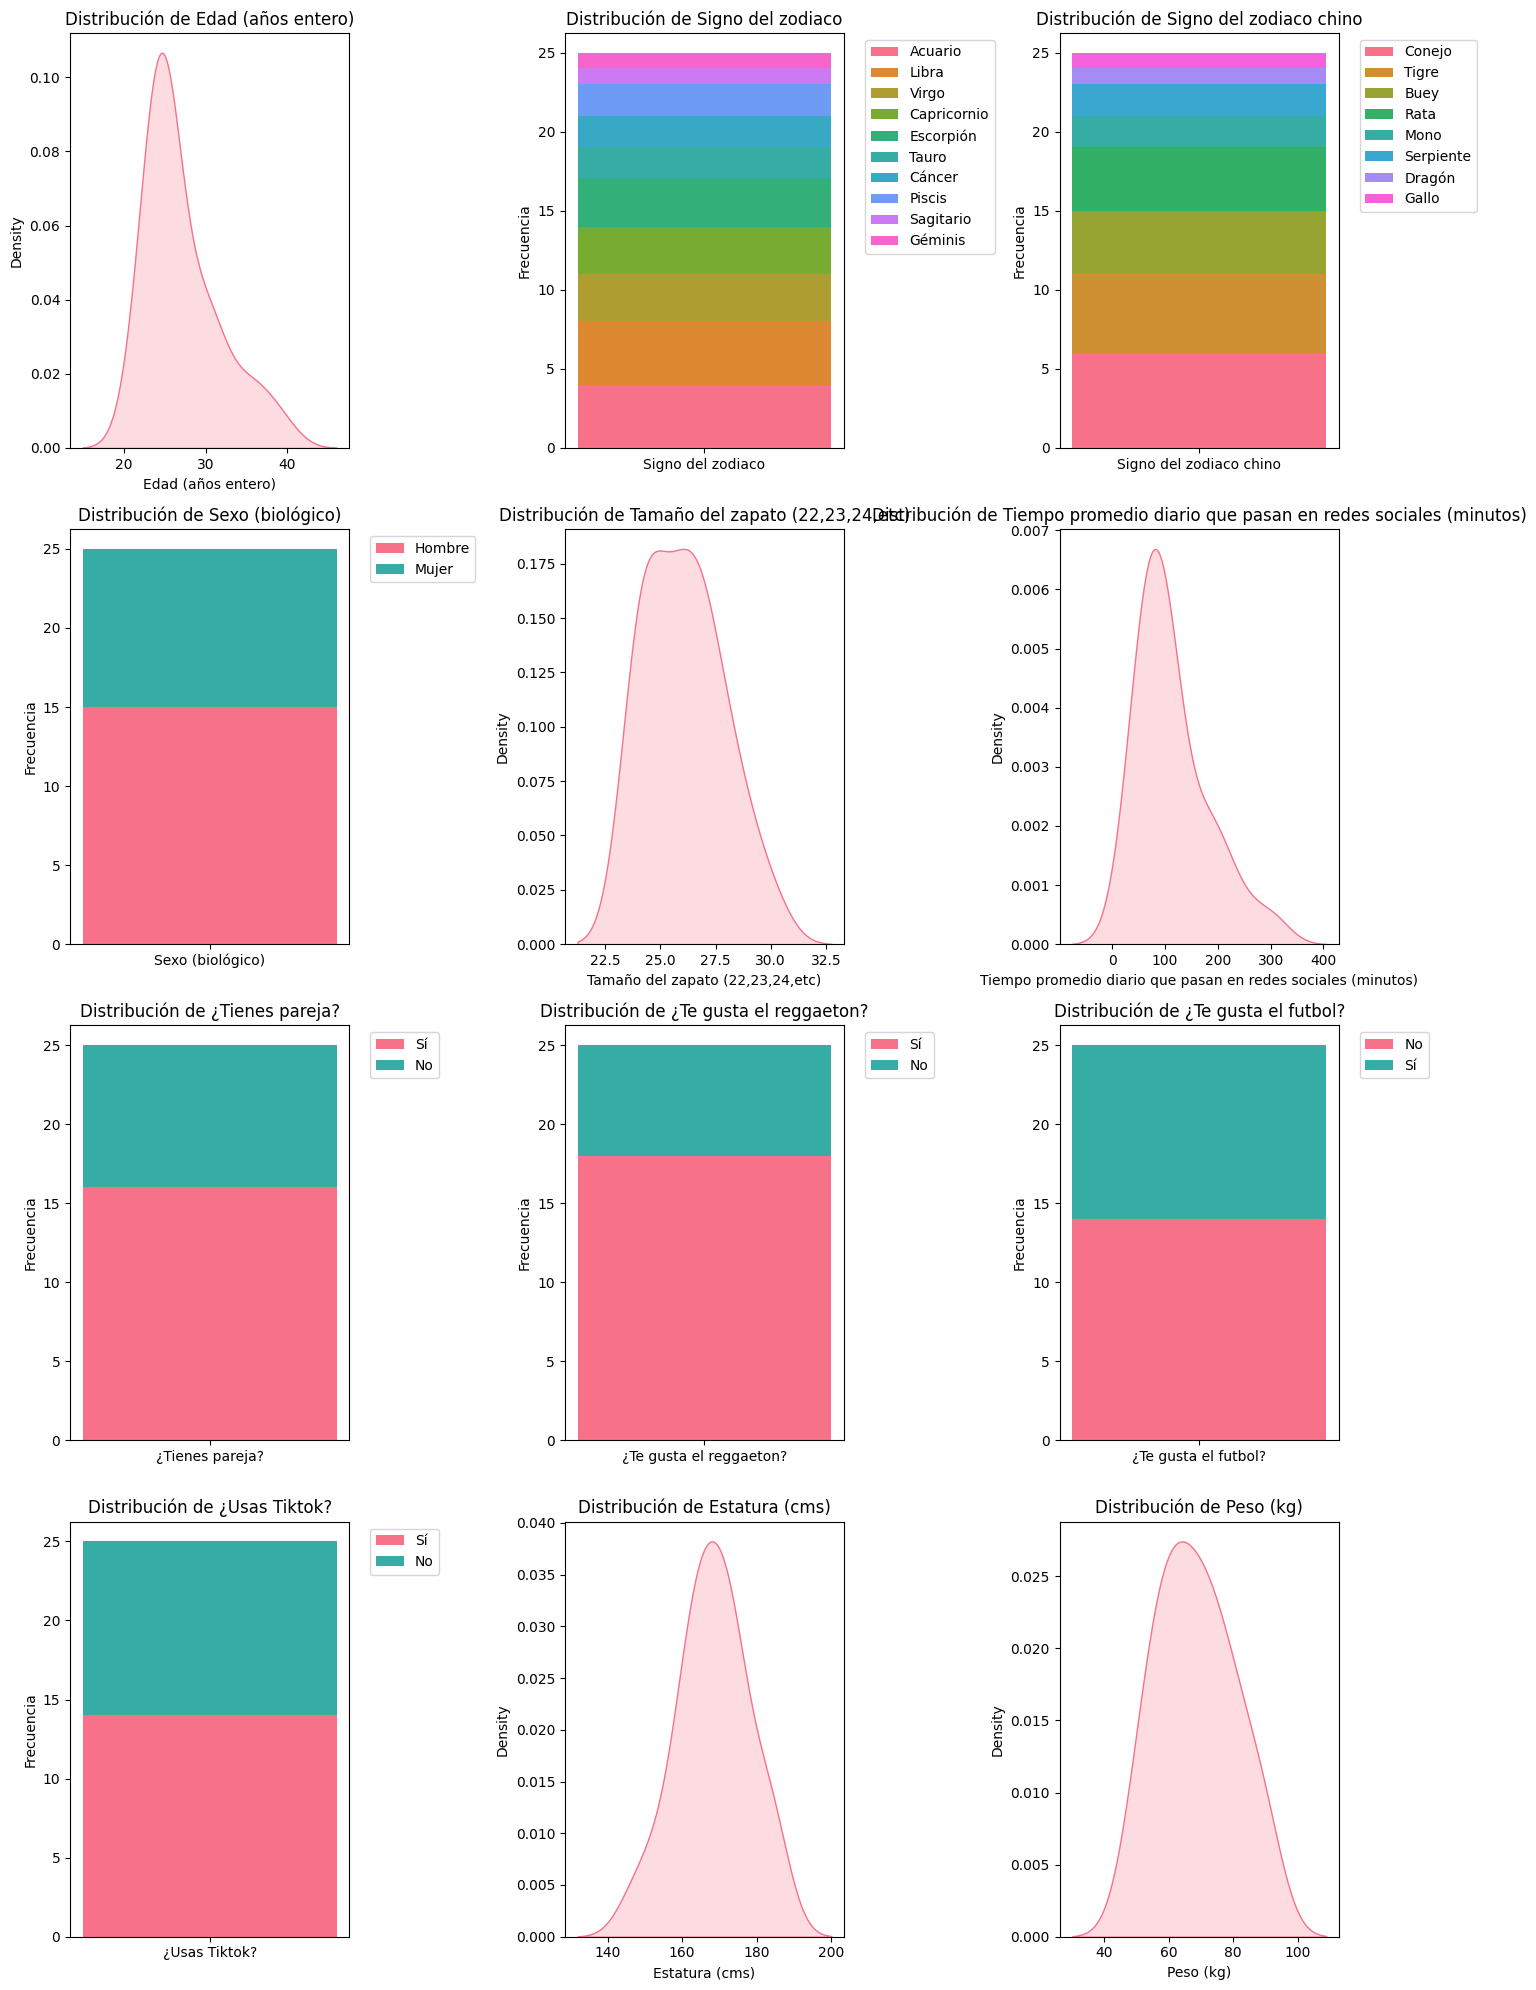

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Get all columns except 'Marca temporal'
cols_to_plot = [col for col in data.columns if col != 'Marca temporal']

# Calculate grid dimensions
n_cols = len(cols_to_plot)
n_rows = (n_cols + 2) // 3  # 3 columns per row
fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

# Plot each variable
for i, col in enumerate(cols_to_plot):
    ax = axes[i]
    
    # Check if the column is numeric or categorical
    if data[col].dtype in ['int64', 'float64']:
        # Numeric variable - use KDE
        sns.kdeplot(data=data, x=col, ax=ax, fill=True)
        ax.set_title(f'Distribución de {col}')
    else:
        # Categorical variable - use single stacked bar
        value_counts = data[col].value_counts()
        colors = sns.color_palette("husl", len(value_counts))
        
        # Create stacked bar with cumulative heights
        bottom = 0
        for j, (category, count) in enumerate(value_counts.items()):
            ax.bar(0, count, bottom=bottom, color=colors[j], label=category)
            bottom += count
        
        ax.set_title(f'Distribución de {col}')
        ax.set_ylabel('Frecuencia')
        ax.set_xticks([0])
        ax.set_xticklabels([col])
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Hide any unused subplots
for i in range(len(cols_to_plot), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


In [6]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import scipy.stats as stats

# 1. Preprocesamiento: excluir 'Marca temporal' y preparar datos
df = data.drop(columns=['Marca temporal'])
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Codificar variables categóricas
encoders = {}
df_encoded = df.copy()
for col in categorical_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str))
    encoders[col] = le

print(f"Variables categóricas: {categorical_cols}")
print(f"Variables numéricas: {numerical_cols}")

# 2. Modelo generativo basado en Gaussian Mixture Model (preserva dependencias)
class GaussianMixtureGenerativeModel:
    def __init__(self, n_components=3):
        self.n_components = n_components
        self.gmm = None
        self.scaler = StandardScaler()
        self.fitted = False
        self.feature_names = None
        
    def fit(self, df_encoded):
        """
        Aprende la distribución conjunta multivariada usando Gaussian Mixture Models
        """
        # Preparar datos - todas las variables juntas
        X = df_encoded.values.astype(float)
        self.feature_names = df_encoded.columns.tolist()
        
        # Estandarizar los datos
        X_scaled = self.scaler.fit_transform(X)
        
        # Ajustar GMM que captura la distribución conjunta
        self.gmm = GaussianMixture(
            n_components=self.n_components,
            covariance_type='full',  # Matriz de covarianza completa para capturar dependencias
            random_state=42
        )
        self.gmm.fit(X_scaled)
        
        self.fitted = True
        print(f"Modelo GMM entrenado exitosamente con {self.n_components} componentes")
        print(f"Log-likelihood: {self.gmm.score(X_scaled):.2f}")
        
    def generate_samples(self, n_samples=1):
        """
        Genera nuevas muestras de la distribución conjunta aprendida
        """
        if not self.fitted:
            raise ValueError("El modelo debe ser entrenado primero")
            
        # Generar muestras del GMM
        X_generated_scaled, _ = self.gmm.sample(n_samples)
        
        # Desestatandardizar
        X_generated = self.scaler.inverse_transform(X_generated_scaled)
        
        # Crear DataFrame
        samples_df = pd.DataFrame(X_generated, columns=self.feature_names)
        
        # Post-procesar para mantener tipos de datos apropiados
        for col in categorical_cols:
            # Redondear y asegurar que estén en el rango válido
            encoded_values = df_encoded[col].unique()
            min_val, max_val = encoded_values.min(), encoded_values.max()
            samples_df[col] = np.clip(np.round(samples_df[col]), min_val, max_val).astype(int)
        
        for col in numerical_cols:
            if col in ['Edad (años entero)', 'Tamaño del zapato (22,23,24,etc)', 
                      'Estatura (cms)', 'Peso (kg)']:
                # Para variables enteras, redondear y aplicar límites razonables
                if 'Edad' in col:
                    samples_df[col] = np.clip(np.round(samples_df[col]), 18, 80).astype(int)
                elif 'zapato' in col:
                    samples_df[col] = np.clip(np.round(samples_df[col]), 22, 50).astype(int)
                elif 'Estatura' in col:
                    samples_df[col] = np.clip(np.round(samples_df[col]), 140, 200).astype(int)
                elif 'Peso' in col:
                    samples_df[col] = np.clip(np.round(samples_df[col]), 40, 120).astype(int)
            else:
                # Para tiempo en redes sociales, mantener positivo
                samples_df[col] = np.clip(samples_df[col], 0, None)
        
        return samples_df

# 3. Entrenar el modelo
modelo_gmm = GaussianMixtureGenerativeModel(n_components=5)
modelo_gmm.fit(df_encoded)

# 4. Generar nuevas muestras
def generar_muestras_gmm(n=25):
    """
    Genera n muestras usando el modelo GMM entrenado que preserva dependencias
    """
    # Generar muestras codificadas
    muestras_encoded = modelo_gmm.generate_samples(n)
    
    # Decodificar variables categóricas
    muestras_decoded = muestras_encoded.copy()
    for col in categorical_cols:
        le = encoders[col]
        # Asegurar que los valores estén en el rango válido antes de decodificar
        valid_range = range(len(le.classes_))
        muestras_encoded[col] = np.clip(muestras_encoded[col], 
                                       min(valid_range), max(valid_range))
        muestras_decoded[col] = le.inverse_transform(muestras_encoded[col].astype(int))
    
    return muestras_decoded

# 5. Verificar dependencias aprendidas
print("\nVerificando que el modelo captura dependencias:")
print("Correlaciones en datos originales:")
correlaciones_orig = df_encoded.corr()
print(correlaciones_orig.round(3))


Variables categóricas: ['Signo del zodiaco', 'Signo del zodiaco chino', 'Sexo (biológico)', '¿Tienes pareja?', '¿Te gusta el reggaeton?', '¿Te gusta el futbol?', '¿Usas Tiktok?']
Variables numéricas: ['Edad (años entero)', 'Tamaño del zapato (22,23,24,etc)', 'Tiempo promedio diario que pasan en redes sociales (minutos)', 'Estatura (cms)', 'Peso (kg)']
Modelo GMM entrenado exitosamente con 5 componentes
Log-likelihood: 38.89

Verificando que el modelo captura dependencias:
Correlaciones en datos originales:
                                                    Edad (años entero)  \
Edad (años entero)                                               1.000   
Signo del zodiaco                                               -0.164   
Signo del zodiaco chino                                          0.250   
Sexo (biológico)                                                -0.265   
Tamaño del zapato (22,23,24,etc)                                 0.426   
Tiempo promedio diario que pasan en redes so


Generadas 25 nuevas muestras sintéticas:


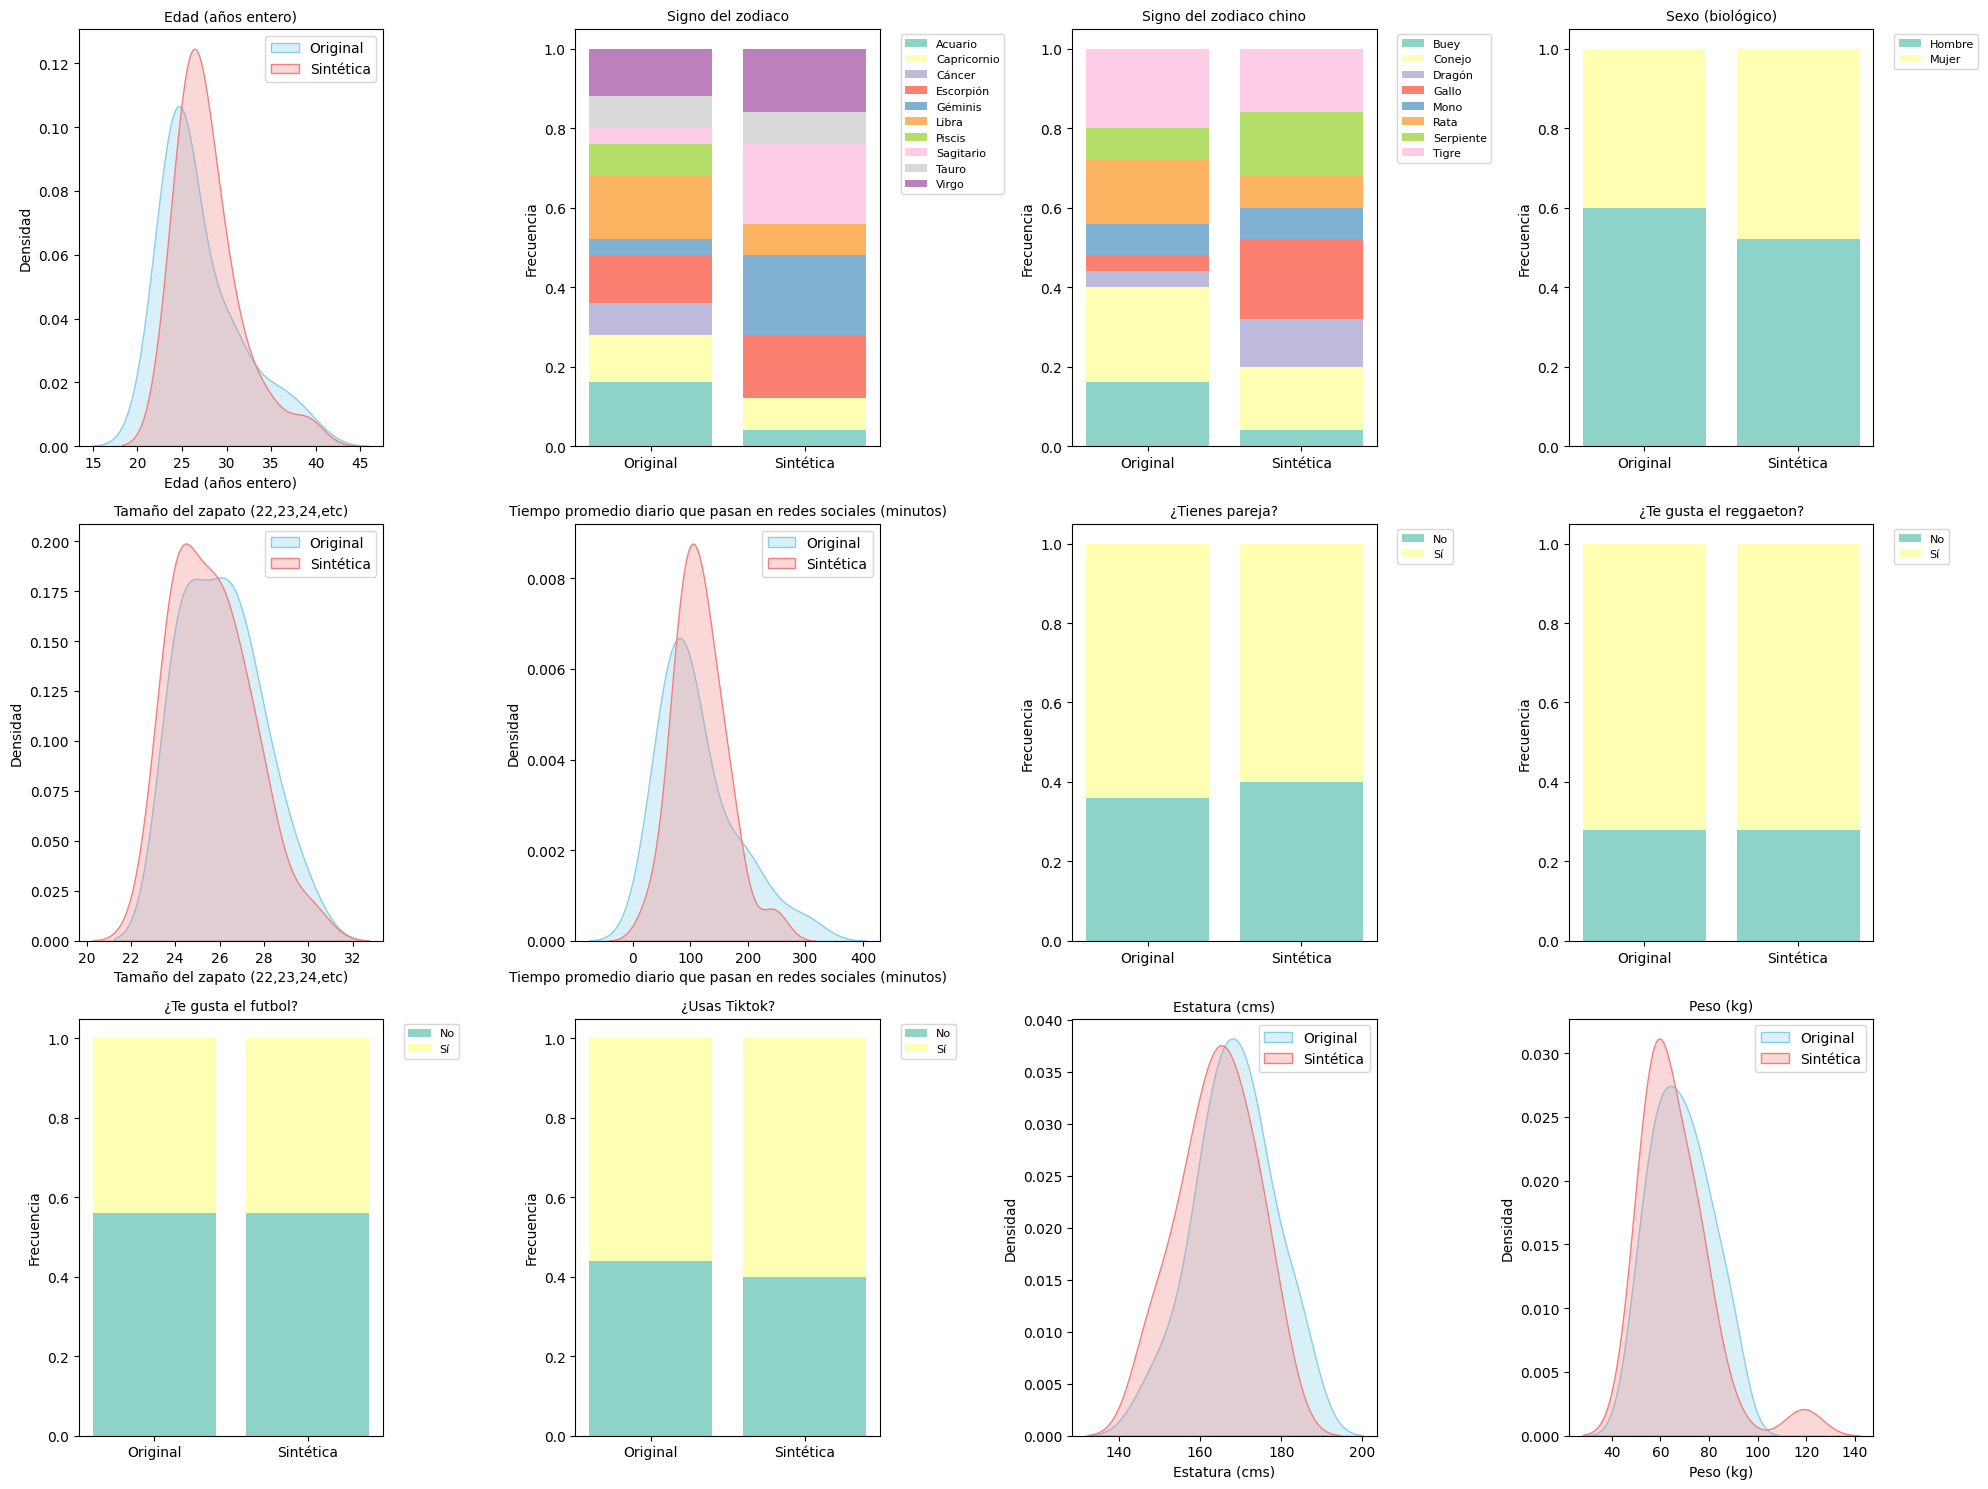

In [8]:
# Generar 25 nuevas muestras
nuevas_muestras = generar_muestras_gmm(25)
print(f"\nGeneradas {len(nuevas_muestras)} nuevas muestras sintéticas:")
nuevas_muestras

import matplotlib.pyplot as plt
import seaborn as sns

# Separar variables continuas y categóricas
categorical = categorical_cols
continuous = [col for col in df.columns if col not in categorical]

# Calcular el número de filas y columnas para los subplots
n_cols = len(df.columns)
n_rows = 3  # 3 filas para mejor distribución
n_subplot_cols = 4  # 4 columnas por fila

fig, axes = plt.subplots(n_rows, n_subplot_cols, figsize=(20, 15))
axes = axes.flatten()  # Aplanar para fácil indexación

for i, col in enumerate(df.columns):
    ax = axes[i]
    if col in categorical:
        # Para variables categóricas: barras apiladas con frecuencias
        orig_counts = data[col].value_counts(normalize=True)
        synth_counts = nuevas_muestras[col].value_counts(normalize=True)
        
        # Obtener todas las categorías únicas
        all_cats = sorted(set(orig_counts.index).union(set(synth_counts.index)), key=str)
        
        # Crear las frecuencias para cada categoría
        orig_freqs = [orig_counts.get(cat, 0) for cat in all_cats]
        synth_freqs = [synth_counts.get(cat, 0) for cat in all_cats]
        
        x = ['Original', 'Sintética']
        
        # Crear barras apiladas
        bottom_orig = [0] * len(all_cats)
        bottom_synth = [0] * len(all_cats)
        
        colors = plt.cm.Set3(range(len(all_cats)))
        
        for j, cat in enumerate(all_cats):
            ax.bar('Original', orig_freqs[j], bottom=sum(orig_freqs[:j]), 
                   label=cat if j < len(all_cats) else None, color=colors[j])
            ax.bar('Sintética', synth_freqs[j], bottom=sum(synth_freqs[:j]), 
                   color=colors[j])
        
        ax.set_ylabel('Frecuencia')
        ax.set_title(f'{col}', fontsize=10)
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    else:
        # Para variables continuas: KDE con sombra
        sns.kdeplot(data=df, x=col, label='Original', color='skyblue', ax=ax, fill=True, alpha=0.3)
        sns.kdeplot(data=nuevas_muestras, x=col, label='Sintética', color='lightcoral', ax=ax, fill=True, alpha=0.3)
        ax.set_xlabel(col)
        ax.set_ylabel('Densidad')
        ax.set_title(f'{col}', fontsize=10)
        ax.legend()

# Ocultar subplots vacíos si los hay
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [9]:
nuevas_muestras.sample()

,Edad (años entero),Signo del zodiaco,Signo del zodiaco chino,Sexo (biológico),"Tamaño del zapato (22,23,24,etc)",Tiempo promedio diario que pasan en redes sociales (minutos),¿Tienes pareja?,¿Te gusta el reggaeton?,¿Te gusta el futbol?,¿Usas Tiktok?,Estatura (cms),Peso (kg)
17,24,Virgo,Serpiente,Hombre,28,245.006245,No,Sí,Sí,Sí,166,55


In [10]:
nuevas_muestras.groupby('Sexo (biológico)').agg({'Estatura (cms)': 'mean','Peso (kg)': 'mean','Tamaño del zapato (22,23,24,etc)': 'mean','Edad (años entero)': 'mean'})

,Estatura (cms),Peso (kg),"Tamaño del zapato (22,23,24,etc)",Edad (años entero)
Sexo (biológico),,,,
Hombre,170.923077,74.384615,27.000000,28.384615
Mujer,156.916667,57.250000,24.166667,27.416667
